In [1]:
from ebmdatalab.bq import cached_read
import matplotlib.pyplot as plt
import pandas as pd

In [141]:
vendors = pd.read_csv('vendors.csv')
# Clean up the input data
vendors['Principal Supplier'] = vendors['Principal Supplier'].str.strip()
vendors.loc[vendors['Principal Supplier'] == 'INPS', 'Principal Supplier'] = 'Vision'  # seems they changed in 2017
vendors = vendors.loc[vendors['Date'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this

start = pd.to_datetime('2016-01-01')
end = pd.to_datetime('2018-12-01')

In [3]:
from ebmdatalab import bq
import importlib
importlib.reload(bq)
measures = ['diltiazem']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.practice_id,
  m.pct_id,
  m.month,
  numerator,
  denominator,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0
ORDER BY
  month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="data/diltiazem.csv.zip".format(measure_id))
    return df


df = get_data('diltiazem')

In [4]:
df['calc_value'] = df['numerator'] / df['denominator']
df['month'] = pd.to_datetime(df['month'])

Text(0.5, 1.0, 'diltiazem measure, mean values per supplier')

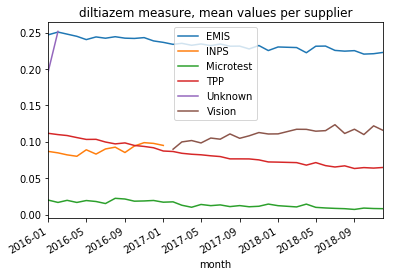

In [5]:
df.groupby(['month', 'supplier']).mean()['calc_value'].unstack().plot.line()
plt.legend(loc='best')
plt.title("diltiazem measure, mean values per supplier")

In [147]:
df.rename(columns={'pct_id':'pct'}, inplace=True)  # The CCG column must be named 'pct' for the maps function
by_pct = df[df['month'] == end].groupby('pct').sum().reset_index()
by_pct['calc_value'] = by_pct['numerator'] / by_pct['denominator']
by_supplier_and_pct = df.groupby(['supplier', 'pct']).sum().reset_index()
by_supplier_and_pct['calc_value'] = by_supplier_and_pct['numerator'] / by_supplier_and_pct['denominator']

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


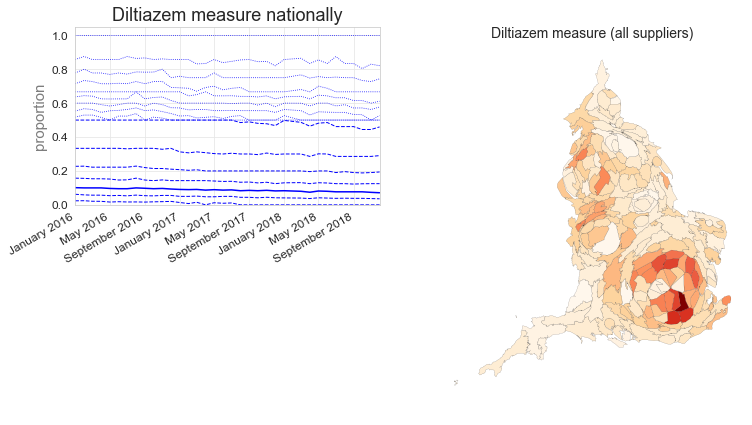

In [148]:
from ebmdatalab import charts
import matplotlib.gridspec as gridspec
from ebmdatalab import maps
import importlib
importlib.reload(maps)

plt.figure(figsize=(12,8))
layout = gridspec.GridSpec(2, 2)
left_ax = plt.subplot(layout[0, 0])
right_subplot = layout[0:2, 1]



charts.deciles_chart(
        df,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure nationally",
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=False,
    ax=left_ax
    )
maps.ccg_map(by_pct, title="Diltiazem measure (all suppliers)", 
             column='calc_value', cartogram=True,
             show_legend=False,
             subplot_spec=right_subplot)

plt.show()

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


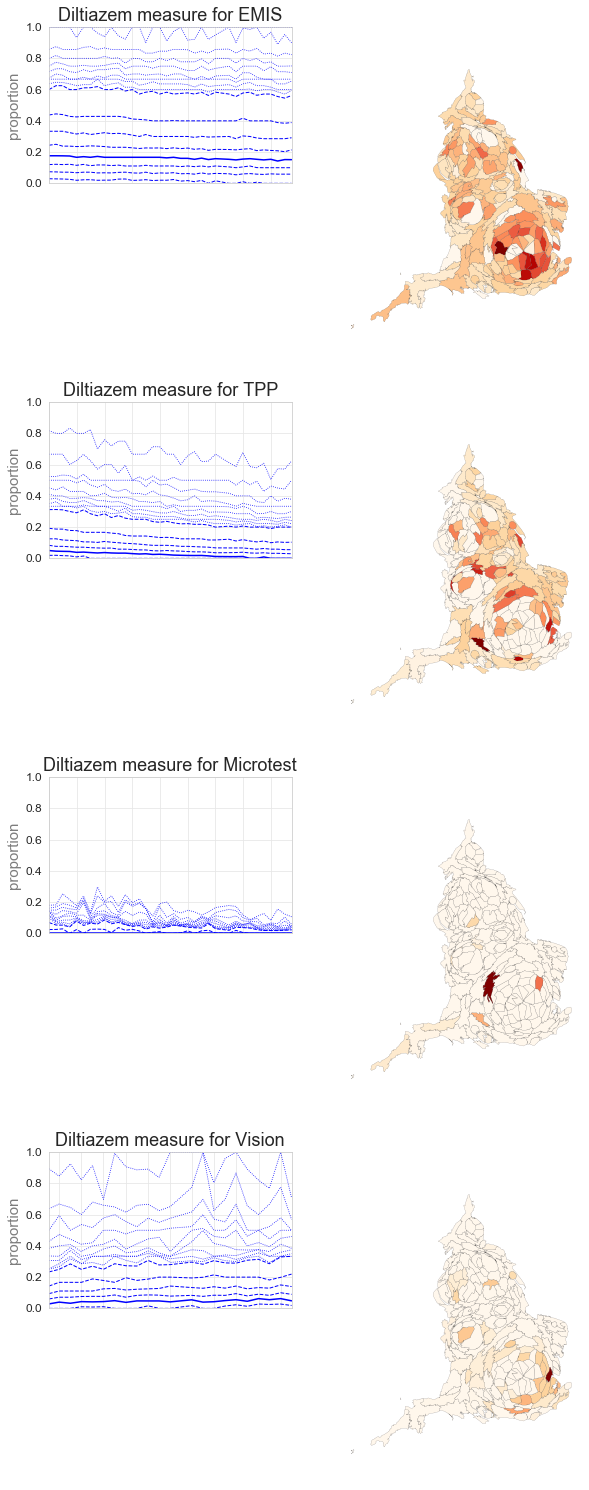

In [145]:


plt.figure(figsize=(20,30))
layout = gridspec.GridSpec(8, 4)
for i, supplier in enumerate(['EMIS', 'TPP', 'Microtest', 'Vision']):
    left_ax = plt.subplot(layout[i * 2, 0])
    right_subplot = layout[(i * 2):(i * 2 + 2), 1]
    #print("right subplot layout[%s]" % (2 - i % 2))
    #print("left ax layout[%s:%s, 0]" % ((i * 2), (i * 2 + 2)))
    #continue
    charts.deciles_chart(
        df[df['supplier'] == supplier],
        period_column='month',
        column='calc_value',
        title="Diltiazem measure for {}".format(supplier),
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=False,
        ax=left_ax
    )
    left_ax.set_ylim([0, 1])
    maps.ccg_map(
        by_supplier_and_pct[by_supplier_and_pct['supplier'] == supplier], 
        column='calc_value', 
        show_legend=False,
        cartogram=True, 
        subplot_spec=right_subplot)
plt.show()

## What do CCGs with a 50/50 emis/tpp split look like?

In [153]:
single_month = df[df['month'] == end]

In [154]:
by_pct_and_supplier = single_month.groupby(['pct', 'supplier']).count().reset_index()
by_pct = single_month.groupby(['pct']).count().reset_index()

In [155]:
# Create a list of CCGs in which between them TPP and EMIS roughly equally dominate the market
both = by_pct_and_supplier.merge(by_pct, how='inner', left_on='pct', right_on='pct')
both['proportion'] = both['practice_id_x'] / both['practice_id_y']
proportions = both[['pct', 'supplier_x', 'proportion']]
interesting_pcts = []
for key, rows in proportions.groupby('pct'):
    emis = tpp = None
    for i, row in rows.iterrows():
        if row['supplier_x'] == 'EMIS':
            emis = row['proportion']
        elif row['supplier_x'] == 'TPP':
            tpp = row['proportion']
    if emis is not None and tpp is not None:
        if emis > 0.4 and tpp > 0.4 and abs(emis - tpp) > fuzz:
            interesting_pcts.append(key)

In [170]:
qwe = pd.DataFrame(interesting_pcts)
qwe['interesting'] = 100
qwe.columns = ['pct', 'interesting']

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


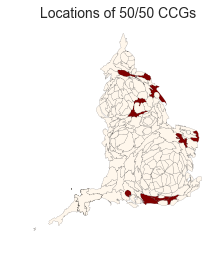

In [177]:
plt.figure(figsize=(6,4))
qwe = pd.concat([qwe, pd.DataFrame([{'pct': '99P', 'interesting': 0}])])
maps.ccg_map(
        qwe, 
        column='interesting', 
        show_legend=False,
        title='Locations of 50/50 CCGs',
        cartogram=True)
plt.show()

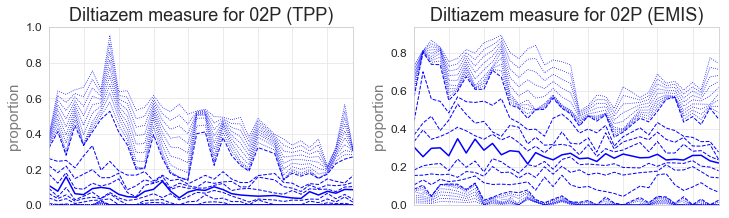

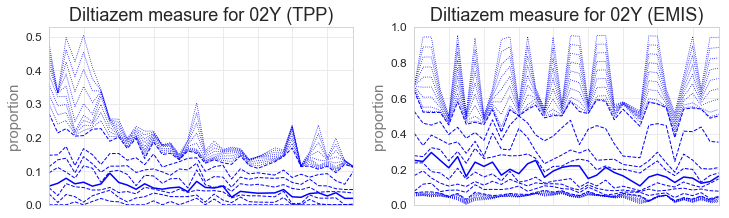

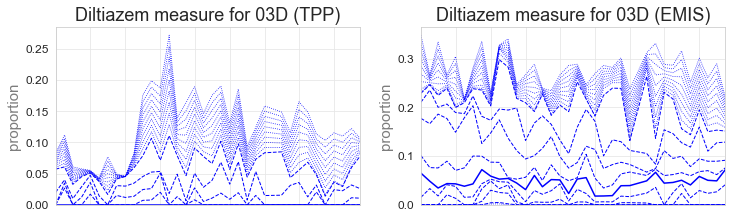

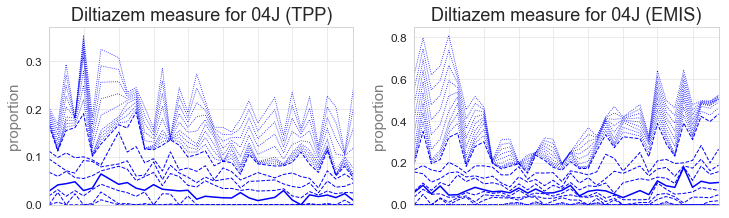

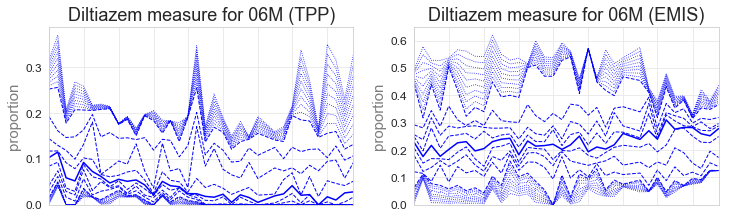

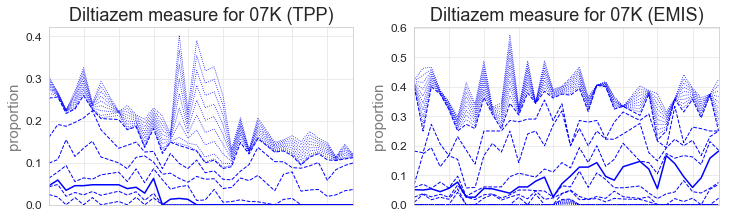

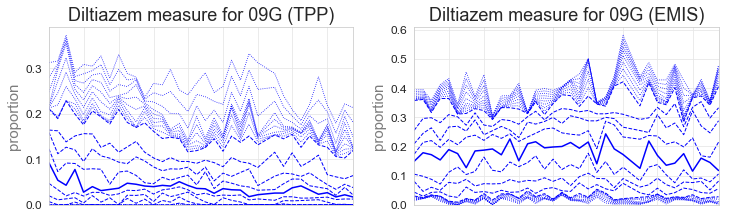

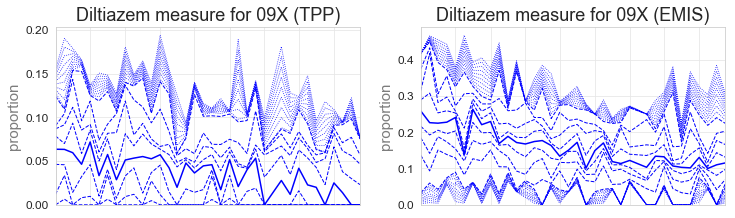

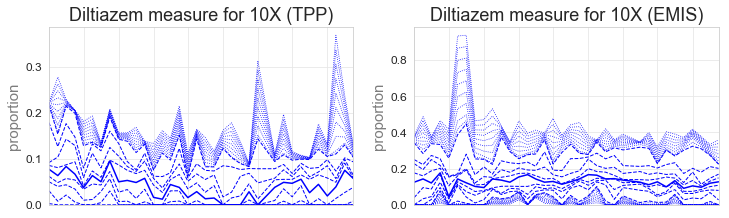

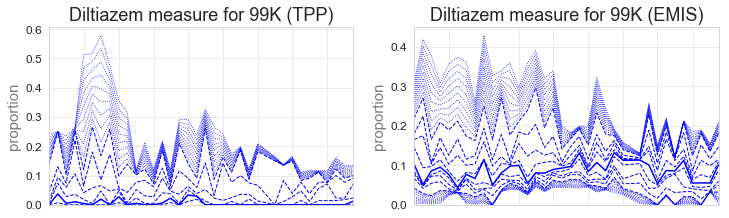

In [156]:
# Plot them side-by-side
for ccg in interesting_pcts:
    plt.figure(figsize=(12,8))
    layout = gridspec.GridSpec(2, 2)
    for cell, supplier in enumerate(['TPP', 'EMIS']):
        charts.deciles_chart(
            df[(df['supplier'] == supplier) & (df['pct'] == ccg)],
            period_column='month',
            column='calc_value',
            title="Diltiazem measure for {} ({})".format(ccg, supplier),
            ylabel="proportion",
            show_outer_percentiles=True,
            show_legend=False,
            ax=plt.subplot(layout[cell])
        )
    plt.show()